In [1]:
import pandas as pd

from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/Google colab Save/kaggle/0.doc_for_me

Mounted at /content/drive
/content/drive/My Drive/Google colab Save/kaggle/0.doc_for_me


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [24]:


# Read the data
X = pd.read_csv('data/house_train.csv', index_col='Id')
X_test_full = pd.read_csv('data/house_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

X_clean = X[my_cols].copy()
X_clean = pd.get_dummies(X_clean)

## Without any parameter setting

In [5]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(random_state=0) # Your code here

# Fit the model
my_model_1.fit(X_train, y_train) # Your code here

[06:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [8]:
# Get predictions
predictions_1 = my_model_1.predict(X_valid) # Your code here
predictions_1[:10]

array([237696.22 , 159064.05 , 108627.734, 212797.8  ,  88389.44 ,
       100484.87 , 262601.5  , 118306.56 , 407057.28 , 157098.17 ],
      dtype=float32)

In [10]:
# Calculate MAE
mae_1 = mean_absolute_error(y_valid, predictions_1) # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 16803.434690710616


## Improve Model 
- with parameter setting
- with cross_val_score and selection n_estimators parameter

In [16]:
# Define the model
my_model_2 = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.1, verbosity=0) # Your code here

# Fit the model
my_model_2.fit(X_train, y_train) # Your code here

# Get predictions
predictions_2 = my_model_2.predict(X_valid)# Your code here

# Calculate MAE
mae_2 = mean_absolute_error(y_valid, predictions_2) # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_2)


Mean Absolute Error: 15918.715218321919


In [21]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
  my_model_2_1 = XGBRegressor(random_state=0, n_estimators = n_estimators, learning_rate=0.1) # Your code here

  # Get scores from cross_validation
  scores = -1 * cross_val_score(my_model_2_1, X_clean, y, cv=5, scoring='neg_mean_absolute_error')

  # Return MAE score
  return scores.mean()

In [33]:
para_candidates = [i for i in range(100, 1001, 100)]
results = {cand : get_score(cand) for cand in para_candidates}

[07:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

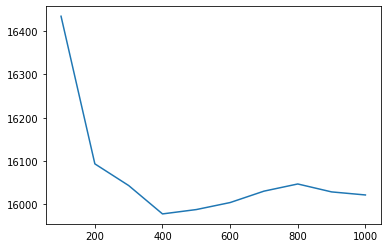

In [34]:
sns.lineplot(x=results.keys(), y=results.values(), palette='pastel')

## Improve Model
- with Stop learning

In [45]:
results

{100: 16434.645090432365,
 200: 16093.165092572774,
 300: 16042.993169413527,
 400: 15977.37235926798,
 500: 15987.44889501284,
 600: 16003.668089148117,
 700: 16030.031421232876,
 800: 16046.641194884418,
 900: 16028.308205800513,
 1000: 16021.215023009421}

In [43]:
# Define the model
my_model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=1) # Your code here

# Fit the model
my_model_3.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid,y_valid)]) # Your code here

# Get predictions
predictions_3 = my_model_3 # Your code here

# Calculate MAE
mae_3 = X_valid # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_2)


[07:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:190317
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:181638
[2]	validation_0-rmse:173425
[3]	validation_0-rmse:165397
[4]	validation_0-rmse:158114
[5]	validation_0-rmse:150922
[6]	validation_0-rmse:144276
[7]	validation_0-rmse:137733
[8]	validation_0-rmse:131708
[9]	validation_0-rmse:125877
[10]	validation_0-rmse:120480
[11]	validation_0-rmse:115234
[12]	validation_0-rmse:110358
[13]	validation_0-rmse:105695
[14]	validation_0-rmse:101643
[15]	validation_0-rmse:97530
[16]	validation_0-rmse:93467.8
[17]	validation_0-rmse:89727.4
[18]	validation_0-rmse:86265.2
[19]	validation_0-rmse:83251.3
[20]	validation_0-rmse:80105.2
[21]	validation_0-rmse:77433.9
[22]	validation_0-rmse:74818.3
[23]	validation_0-rmse:72176.3
[24]	validation_0-rmse:69897.6
[25]	validation_0-rmse:67655.2
[26]	validation_0-rmse:65498.